In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import precision_score, recall_score, f1_score
import tensorflow.keras.backend as K
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report, precision_recall_curve

2025-03-13 17:08:17.644681: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-13 17:08:17.652658: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1741882097.661376   64126 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1741882097.664042   64126 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-13 17:08:17.674187: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [3]:
df=pd.read_csv("../datasets/sensor.csv")
#sensors_to_drop = ['Unnamed: 0', 'timestamp','sensor_15', 'sensor_50']
sensors_to_drop = ['Unnamed: 0','sensor_15', 'sensor_50']
df = df.drop(columns=sensors_to_drop)

sensor_cols = df.columns[df.isnull().any()].tolist()
df[sensor_cols] = df[sensor_cols].interpolate(method='linear')

# If any remaining NaNs, use forward/backward fill
df[sensor_cols] = df[sensor_cols].fillna(method='ffill')
df[sensor_cols] = df[sensor_cols].fillna(method='bfill')
y=df["machine_status"]
X=df.drop(columns=['machine_status'])

/tmp/ipykernel_64126/1443057295.py:10: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[sensor_cols] = df[sensor_cols].fillna(method='ffill')
/tmp/ipykernel_64126/1443057295.py:11: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[sensor_cols] = df[sensor_cols].fillna(method='bfill')


In [4]:
first_broken_idx = y[y == "BROKEN"].index[0]
df.iloc[:first_broken_idx-200].to_csv("../datasets/initial_data.csv",index=False)
X=X.drop(columns=["timestamp"])
# 2. Isolate normal data up to first BROKEN for training
train_X = X.iloc[:first_broken_idx-200].values
n_features = train_X.shape[1]  # number of sensors (~50)

# 3. Normalize the training data
train_mean = train_X.mean(axis=0)
train_std = train_X.std(axis=0)
train_X_normalized = (train_X - train_mean) / train_std

In [5]:
class Autoencoder(Model):
    def __init__(self, n_features):
        super(Autoencoder, self).__init__()
        
        # Encoder
        self.encoder = tf.keras.Sequential([
            layers.Dense(32, activation='relu', input_shape=(n_features,)),
            layers.Dense(16, activation='relu'),
            layers.Dense(8, activation='relu')  # bottleneck
        ])
        
        # Decoder
        self.decoder = tf.keras.Sequential([
            layers.Dense(16, activation='relu'),
            layers.Dense(32, activation='relu'),
            layers.Dense(n_features, activation='linear')
        ])
    
    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded
# 5. Create and compile the model
autoencoder = Autoencoder(n_features)
autoencoder.compile(optimizer='adam', loss='mse')

/home/henrik/anaconda3/envs/tf-gpu/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-03-13 17:08:20.688337: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:47] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
I0000 00:00:1741882100.689225   64126 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13556 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4060 Ti, pci bus id: 0000:01:00.0, compute capability: 8.9


In [6]:

# 6. Train the autoencoder
history = autoencoder.fit(
    train_X_normalized, 
    train_X_normalized,
    epochs=20,
    batch_size=256,
    validation_split=0.2,
    verbose=1
)

Epoch 1/20


I0000 00:00:1741882101.465903   85177 service.cc:148] XLA service 0x71866000db50 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1741882101.465921   85177 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 4060 Ti, Compute Capability 8.9
2025-03-13 17:08:21.483065: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1741882101.564479   85177 cuda_dnn.cc:529] Loaded cuDNN version 90300


 1/53 ━━━━━━━━━━━━━━━━━━━━ 2:00 2s/step - loss: 0.8513

I0000 00:00:1741882103.329546   85177 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
2025-03-13 17:08:24.086027: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_252', 40 bytes spill stores, 40 bytes spill loads



53/53 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - loss: 0.8799 - val_loss: 1.7693
Epoch 2/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6887 - val_loss: 1.5676
Epoch 3/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5456 - val_loss: 1.4753
Epoch 4/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4482 - val_loss: 1.4210
Epoch 5/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4137 - val_loss: 1.4128
Epoch 6/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3821 - val_loss: 1.4185
Epoch 7/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3477 - val_loss: 1.4257
Epoch 8/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.3318 - val_loss: 1.4201
Epoch 9/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3173 - val_loss: 1.4121
Epoch 10/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.3052 - val_loss: 1.4270
Epoch 11/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3000 - val_loss: 1.4413
Epoch 12/20
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2903 - val_loss: 1.4538

In [7]:
#broken_indices = y[y == "BROKEN"].index
#second_broken_idx = broken_indices[1]
#test_start_idx = max(0, second_broken_idx - 200)
#test_X = X.iloc[test_start_idx:second_broken_idx + 1].values
#test_X_normalized = (test_X - train_mean) / train_std

# 8. Get reconstructions and calculate reconstruction error
#reconstructions = autoencoder.predict(test_X_normalized)
#mse = np.mean(np.square(test_X_normalized - reconstructions), axis=1)
mean1 = X.mean(axis=0)
std1 = X.std(axis=0)
X_normalized = (X - mean1) / std1
reconstructions = autoencoder.predict(X_normalized)
mse = np.mean(np.square(X_normalized - reconstructions), axis=1)
offset=len(df)-len(mse)

6885/6885 ━━━━━━━━━━━━━━━━━━━━ 3s 401us/step


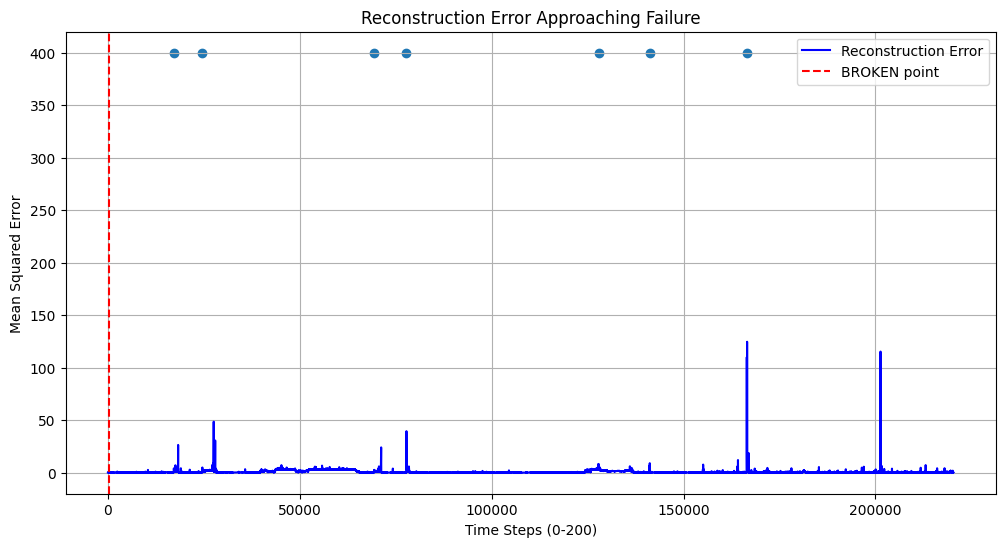

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(range(len(mse)), mse, 'b-', label='Reconstruction Error')
plt.scatter(y[y == "BROKEN"].index-offset, 100+np.zeros(len(y[y == "BROKEN"].index), dtype=int))  # Initialize an array of zeros), 'b-', label='Reconstruction Error')
#plt.scatter(y[y == "RECOVERING"].index-offset, 200+np.zeros(len(y[y == "RECOVERING"].index), dtype=int))  # Initialize an array of zeros), 'b-', label='Reconstruction Error')
plt.axvline(x=200, color='r', linestyle='--', label='BROKEN point')
plt.title('Reconstruction Error Approaching Failure')
plt.xlabel('Time Steps (0-200)')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.grid(True)
plt.show()